Importing Tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

# To run only on CPU:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

Getting Data

In [5]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

# Get this dataset
data_dir = pathlib.Path("../Dataset")

image_count = len(list(data_dir.glob("*/*.jp*g")))
print("Images available to use: " + str(image_count))

GPUs Available:  []
Images available to use: 14566


In [6]:
# Put into an image dataset.

batch_size = 64
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(F"Classes: {class_names}")

Found 14571 files belonging to 2 classes.
Using 11657 files for training.
Found 14571 files belonging to 2 classes.
Using 2914 files for validation.
Classes: ['Guns', 'No Guns']


Visualizing Dataset

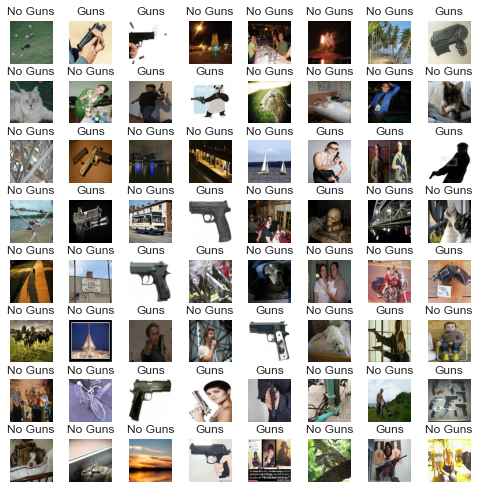

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig = plt.figure(figsize=(8, 8))

for images, labels in train_ds.take(1):
    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[labels[i]], fontsize=12)
        plt.axis("off")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.savefig("Pictures/sample_img.jpg")
plt.show()

Performance Tuning

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the Model!

In [28]:
num_classes = len(class_names)

model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=True, weights=None, input_shape=(img_width, img_height, 3),
    classes=num_classes, classifier_activation="softmax"
)

tf.keras.utils.plot_model(model, to_file="Pictures/InceptionV3.png")
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

In [29]:
# Compile model
model.compile(optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy", "mse"])

# Save model here after training
checkpoint_path = "inception_v3_weights/inception_v3.ckpt"

# If weights there, load
# model.load_weights(checkpoint_path) 

In [30]:
import csv
import tensorflow.keras.backend as K

# TF callbacks for training

# Store model information at the end of every epoch
class StoreModelHistory(keras.callbacks.Callback):

  def on_epoch_end(self,batch,logs=None):
    if ('lr' not in logs.keys()):
      logs.setdefault('lr',0)
      logs['lr'] = K.get_value(self.model.optimizer.lr)

    if not ('model_history.csv' in os.listdir("./")):
      with open('./model_history.csv','a') as f:
        y=csv.DictWriter(f,logs.keys())
        y.writeheader()

    with open('./model_history.csv','a') as f:
      y=csv.DictWriter(f,logs.keys())
      y.writerow(logs)



In [31]:
# Start training!
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[StoreModelHistory()]
)
# model.set_weights(save_best_model.best_weights)
model.save_weights(checkpoint_path)

Epoch 1/15
183/183 [==============================] - 864s 5s/step - loss: 0.4435 - accuracy: 0.8166 - mse: 0.3768 - val_loss: 3.8125 - val_accuracy: 0.3868 - val_mse: 0.4868 - lr: 0.0010
Epoch 2/15
183/183 [==============================] - 842s 5s/step - loss: 0.3200 - accuracy: 0.8707 - mse: 0.4062 - val_loss: 0.8136 - val_accuracy: 0.6891 - val_mse: 0.3906 - lr: 0.0010
Epoch 3/15
183/183 [==============================] - 848s 5s/step - loss: 0.2914 - accuracy: 0.8819 - mse: 0.4146 - val_loss: 0.5665 - val_accuracy: 0.8020 - val_mse: 0.4214 - lr: 0.0010
Epoch 4/15
183/183 [==============================] - 850s 5s/step - loss: 0.2625 - accuracy: 0.8953 - mse: 0.4215 - val_loss: 0.4571 - val_accuracy: 0.8425 - val_mse: 0.4477 - lr: 0.0010
Epoch 5/15
183/183 [==============================] - 836s 5s/step - loss: 0.2385 - accuracy: 0.9048 - mse: 0.4294 - val_loss: 0.3723 - val_accuracy: 0.8555 - val_mse: 0.4347 - lr: 0.0010
Epoch 6/15
183/183 [==============================] - 836s 5

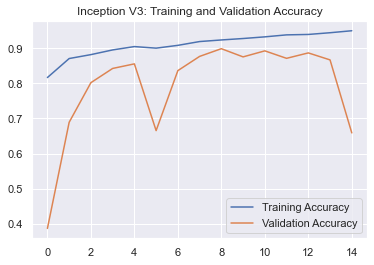

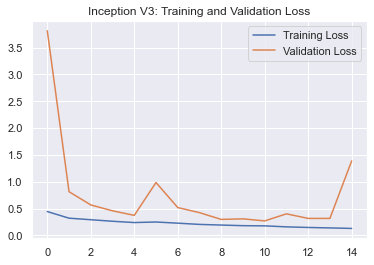

In [33]:
model.save_weights(checkpoint_path)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Inception V3: Training and Validation Accuracy')
plt.savefig("Pictures/InceptionV3_accuracy.png")
plt.show()

# plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Inception V3: Training and Validation Loss')
plt.savefig("Pictures/inceptionv3_loss.png")
plt.show()

In [34]:
model.fit(train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=[StoreModelHistory()]
)

Epoch 1/15
183/183 [==============================] - 881s 5s/step - loss: 0.1232 - accuracy: 0.9514 - mse: 0.4644 - val_loss: 0.6974 - val_accuracy: 0.7807 - val_mse: 0.4422 - lr: 0.0010
Epoch 2/15
183/183 [==============================] - 853s 5s/step - loss: 0.1067 - accuracy: 0.9572 - mse: 0.4682 - val_loss: 1.2831 - val_accuracy: 0.7673 - val_mse: 0.4730 - lr: 0.0010
Epoch 3/15
183/183 [==============================] - 839s 5s/step - loss: 0.0996 - accuracy: 0.9629 - mse: 0.4706 - val_loss: 4.4512 - val_accuracy: 0.4578 - val_mse: 0.4754 - lr: 0.0010
Epoch 4/15
183/183 [==============================] - 835s 5s/step - loss: 0.0967 - accuracy: 0.9644 - mse: 0.4711 - val_loss: 0.3300 - val_accuracy: 0.9077 - val_mse: 0.4732 - lr: 0.0010
Epoch 5/15
183/183 [==============================] - 837s 5s/step - loss: 0.0821 - accuracy: 0.9666 - mse: 0.4759 - val_loss: 1.7485 - val_accuracy: 0.6908 - val_mse: 0.4603 - lr: 0.0010
Epoch 6/15
183/183 [==============================] - 832s 5

In [1]:
import sklearn.metrics as metrics

def print_results(y_test, y_pred):
    # Show the test data's result
    print("Set results:")
    print("------------------------------------------------")
    # y_test = y_test.argmax(axis=1)
    # y_pred = y_pred.argmax(axis=1)
    print(metrics.confusion_matrix(y_test, y_pred))
    print('kappa:       ', metrics.cohen_kappa_score(y_test, y_pred))
    print('accuracy:    ', metrics.accuracy_score(y_test, y_pred))
    print('recall:      ', metrics.recall_score(y_test, y_pred, average=None))
    print('precision:   ', metrics.precision_score(y_test, y_pred, average=None))
    print('f_1:         ', metrics.f1_score(y_test, y_pred, average=None))


for images, labels in val_ds.take(5):
    fig = plt.figure(figsize=(8, 8))
    label_pred = model.predict(images)
    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(class_names[labels[i]], fontsize=12, color = "black" if np.argmax(label_pred) else "red")
        plt.axis("off")
    plt.show()
    print_results(labels, np.argmax(label_pred, axis=1))


NameError: name 'val_ds' is not defined

Analyzing batch 0
Analyzing batch 1
Analyzing batch 2
Analyzing batch 3
Analyzing batch 4
Analyzing batch 5
Analyzing batch 6
Analyzing batch 7
Analyzing batch 8
Analyzing batch 9
Analyzing batch 10
Analyzing batch 11
Analyzing batch 12
Analyzing batch 13
Analyzing batch 14
Analyzing batch 15
Analyzing batch 16
Analyzing batch 17
Analyzing batch 18
Analyzing batch 19
Analyzing batch 20
Analyzing batch 21
Analyzing batch 22
Analyzing batch 23
Analyzing batch 24
Analyzing batch 25
Analyzing batch 26
Analyzing batch 27
Analyzing batch 28
Analyzing batch 29
Analyzing batch 30
Analyzing batch 31
Analyzing batch 32
Analyzing batch 33
Analyzing batch 34
Analyzing batch 35
Analyzing batch 36
Analyzing batch 37
Analyzing batch 38
Analyzing batch 39
Analyzing batch 40
Analyzing batch 41
Analyzing batch 42
Analyzing batch 43
Analyzing batch 44
Analyzing batch 45


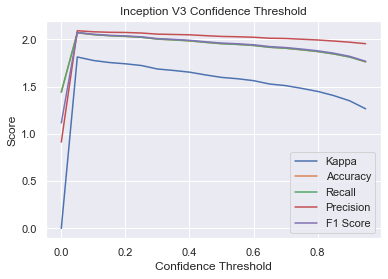

Best confidence threshold calculated at 0.15000000000000002, with an accuracy of 0.984375


In [41]:
# For a batch, find the best confidence threshold.

x_points = np.arange(0, 1, 0.05)
y_point1 = np.zeros(len(x_points))
y_point2 = np.zeros(len(x_points))
y_point3 = np.zeros(len(x_points))
y_point4 = np.zeros(len(x_points))
y_point5 = np.zeros(len(x_points))
batch = 0

lowest_val = 0
x_lowval = 0
for images, labels in val_ds.take(300):
    print(F"Analyzing batch {batch}")
    label_pred = model.predict(images)
    x_point = 0
    for thresh in x_points:
        acc = (metrics.accuracy_score(labels, [i[1] > thresh for i in label_pred]))
        y_point1[x_point] += (metrics.cohen_kappa_score(labels, [i[1] > thresh for i in label_pred]))
        y_point2[x_point] += acc
        y_point3[x_point] += (metrics.recall_score(labels, [i[1] > thresh for i in label_pred], average='weighted'))
        y_point4[x_point] += (metrics.precision_score(labels, [i[1] > thresh for i in label_pred], average='weighted', zero_division=0))
        if(acc > lowest_val):
            x_lowval = thresh
            lowest_val = acc
        y_point5[x_point] += (metrics.f1_score(labels, [i[1] > thresh for i in label_pred], average='weighted'))
        x_point += 1
    batch += 1

y_point1 /= len(y_point1)
y_point2 /= len(y_point2)
y_point3 /= len(y_point3)
y_point4 /= len(y_point4)
y_point5 /= len(y_point5)


fig, ax = plt.subplots()
plot_1, = plt.plot(x_points, y_point1, label = "Kappa")
plot_2, = plt.plot(x_points, y_point2, label = "Accuracy")
plot_3, = plt.plot(x_points, y_point3, label = "Recall")
plot_4, = plt.plot(x_points, y_point4, label = "Precision")
plot_5, = plt.plot(x_points, y_point5, label = "F1 Score")
ax.legend(handles=[plot_1, plot_2, plot_3, plot_4, plot_5])
plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.title("Inception V3 Confidence Threshold")

plt.savefig("Pictures/inceptionv3_confthresh_secepoch.png")

plt.show()

print(F"Best confidence threshold calculated at {x_lowval}, with an accuracy of {lowest_val}")
